Curve Building, script 1 of the whole program, Chi Zhang

## LIBOR and SOFR curve loading

In [1]:
import pandas as pd
from math import exp
import matplotlib.pyplot as plt

In [3]:
LIBOR_data = pd.read_excel(r'C:\Users\Richard\Desktop\CurrentTerm\ISYE 8900\CurveFrcst-Using-ManifoldLrn\Data\WklyLIBOR.xlsx', sheet_name=None)
#LIBOR_data.keys()

In [4]:
for key in LIBOR_data:
    if key == '181102':
        LIBOR_zero = LIBOR_data[key]['Zero Rate'].to_frame(name = key)
        LIBOR_fwd = LIBOR_data[key]['Forward Rate'].to_frame(name = key)
    else:
        LIBOR_zero[key] = LIBOR_data[key]['Zero Rate']
        LIBOR_fwd[key] = LIBOR_data[key]['Forward Rate']
LIBOR_zero = LIBOR_zero.T
LIBOR_fwd = LIBOR_fwd.T

In [7]:
LIBOR_zero.columns = [3 * (x+1) for x in LIBOR_zero.columns]
LIBOR_zero
# each row is a sample (weekly), each row is a TTM (month)

,3,6,9,12,15,18,21,24,27,30,...,333,336,339,342,345,348,351,354,357,360
181102,2.61972,2.619717,2.774752,2.854803,2.932020,2.993549,3.041323,3.071053,3.087379,3.101980,...,3.325801,3.324922,3.323999,3.323051,3.322096,3.321101,3.320063,3.318991,3.317906,3.316760
181109,2.64565,2.645652,2.787011,2.867154,2.943816,3.005727,3.053632,3.080879,3.094139,3.106960,...,3.274852,3.273796,3.272711,3.271608,3.270523,3.269381,3.268219,3.267033,3.265851,3.264617
181116,2.67221,2.672210,2.769769,2.826092,2.880055,2.923548,2.956085,2.967827,2.968256,2.971993,...,3.198483,3.197749,3.196980,3.196180,3.195376,3.194512,3.193610,3.192671,3.191713,3.190692
181123,2.71923,2.719228,2.806461,2.847600,2.890131,2.926382,2.953094,2.966664,2.972859,2.978062,...,3.182218,3.181558,3.180872,3.180150,3.179415,3.178641,3.177825,3.176974,3.176107,3.175183
181130,2.76469,2.764687,2.833875,2.863447,2.895275,2.924858,2.945426,2.945855,2.939158,2.936833,...,3.126252,3.125658,3.125033,3.124374,3.123658,3.122894,3.122091,3.121237,3.120320,3.119348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
201002,0.23667,0.236672,0.239540,0.225065,0.217731,0.213807,0.214528,0.217002,0.221080,0.225428,...,1.144198,1.145238,1.146219,1.147112,1.147898,1.148599,1.149209,1.149715,1.150107,1.150396
201009,0.22718,0.227178,0.233349,0.224311,0.219946,0.219248,0.223241,0.230714,0.240486,0.249191,...,1.247444,1.248605,1.249700,1.250711,1.251614,1.252437,1.253175,1.253813,1.254338,1.254765
201016,0.22135,0.221351,0.230009,0.219294,0.212997,0.211585,0.216810,0.223916,0.231390,0.239202,...,1.197151,1.198118,1.199020,1.199843,1.200570,1.201222,1.201795,1.202276,1.202657,1.202949
201023,0.21945,0.219446,0.233067,0.224358,0.218921,0.217158,0.222589,0.230759,0.238936,0.247750,...,1.320828,1.321901,1.322903,1.323819,1.324628,1.325354,1.325992,1.326530,1.326956,1.327283


In [8]:
LIBOR_fwd.columns = [3 * (x+1) for x in LIBOR_fwd.columns]

In [9]:
SOFR_data = pd.read_excel(r'C:\Users\Richard\Desktop\CurrentTerm\ISYE 8900\CurveFrcst-Using-ManifoldLrn\Data\WklySOFR.xlsx', sheet_name=None)
#SOFR_data.keys()

In [10]:
for key in SOFR_data:
    if key == '181102':
        SOFR_zero = SOFR_data[key]['Zero Rate'].to_frame(name = key)
        SOFR_fwd = SOFR_data[key]['Forward Rate'].to_frame(name = key)
    else:
        SOFR_zero[key] = SOFR_data[key]['Zero Rate']
        SOFR_fwd[key] = SOFR_data[key]['Forward Rate']
SOFR_zero = SOFR_zero.T
SOFR_fwd = SOFR_fwd.T

In [11]:
SOFR_zero.columns = [3 * (x+1) for x in SOFR_zero.columns]
#SOFR_zero

In [12]:
SOFR_fwd.columns = [3 * (x+1) for x in SOFR_fwd.columns]
#SOFR_fwd

## Treasury yield curve loading and constructing

In [13]:
# nelson siegel swenson model: take four curve shape parameters and two hump date parameters, for each given tenor T
def NSS_zero_cstrct(T, beta0,beta1,beta2,beta3,tau1,tau2):
    # zero rate
    if T < 1/365: T = 1/365
    exp_tt1 = exp(-T/tau1)
    exp_tt2 = exp(-T/tau2)
    factor1 = (1 - exp_tt1) / (T / tau1)
    factor2 = factor1 - exp_tt1
    factor3 = (1 - exp_tt2) / (T / tau2) - exp_tt2
    res = beta0 + beta1*factor1 + beta2*factor2 + beta3*factor3
    return res

def NSS_fwd_cstrct(T, beta0,beta1,beta2,beta3,tau1,tau2):
    # forward rate
    if T < 1/365: T = 1/365
    exp_tt1 = exp(-T/tau1)
    exp_tt2 = exp(-T/tau2)
    return beta0 + beta1*exp_tt1 + beta2*exp_tt1*T/tau1 + beta3*exp_tt2*T/tau2

In [14]:
Treasury_data = pd.read_csv(r'C:\Users\Richard\Desktop\CurrentTerm\ISYE 8900\CurveFrcst-Using-ManifoldLrn\Data\feds200628.csv', index_col = 'Date', usecols = ['Date','BETA0','BETA1','BETA2','BETA3','TAU1','TAU2'], skiprows=9)
Treasury_data

,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
Date,,,,,,
1961-06-14,3.917606,-1.277955,-1.949397,0.000000,0.339218,-999.990000
1961-06-15,3.978498,-1.257404,-2.247617,0.000000,0.325775,-999.990000
1961-06-16,3.984350,-1.429538,-1.885024,0.000000,0.348817,-999.990000
1961-06-19,4.004379,-0.723311,-3.310743,0.000000,0.282087,-999.990000
1961-06-20,3.985789,-0.900432,-2.844809,0.000000,0.310316,-999.990000
...,...,...,...,...,...,...
2021-01-04,5.484257,-5.274936,-4.884348,-8.691812,3.254356,18.935793
2021-01-05,5.720749,-5.513988,-5.025172,-9.189046,3.285304,19.250796
2021-01-06,6.333407,-6.130441,-5.363008,-10.488664,3.346462,19.919670


## Index format transform

In [15]:
LIBOR_zero.index = pd.to_datetime(LIBOR_zero.index, format = '%y%m%d')
LIBOR_zero.index

DatetimeIndex(['2018-11-02', '2018-11-09', '2018-11-16', '2018-11-23',
               '2018-11-30', '2018-12-07', '2018-12-14', '2018-12-21',
               '2018-12-28', '2019-01-04',
               ...
               '2020-08-28', '2020-09-04', '2020-09-11', '2020-09-18',
               '2020-09-25', '2020-10-02', '2020-10-09', '2020-10-16',
               '2020-10-23', '2020-10-30'],
              dtype='datetime64[ns]', length=105, freq=None)

In [16]:
LIBOR_fwd.index = pd.to_datetime(LIBOR_fwd.index, format = '%y%m%d')
SOFR_zero.index = pd.to_datetime(SOFR_zero.index, format = '%y%m%d')
SOFR_fwd.index = pd.to_datetime(SOFR_fwd.index, format = '%y%m%d')

In [17]:
Treasury_data.index = pd.to_datetime(Treasury_data.index, infer_datetime_format=True)
Treasury_data.index

DatetimeIndex(['1961-06-14', '1961-06-15', '1961-06-16', '1961-06-19',
               '1961-06-20', '1961-06-21', '1961-06-22', '1961-06-23',
               '1961-06-26', '1961-06-27',
               ...
               '2020-12-28', '2020-12-29', '2020-12-30', '2020-12-31',
               '2021-01-01', '2021-01-04', '2021-01-05', '2021-01-06',
               '2021-01-07', '2021-01-08'],
              dtype='datetime64[ns]', name='Date', length=15543, freq=None)

In [18]:
Treasury_data = Treasury_data.loc[LIBOR_zero.index]
Treasury_data

,BETA0,BETA1,BETA2,BETA3,TAU1,TAU2
2018-11-02,3.659050,-1.657847,-0.000061,-1.523731,0.501227,2.650654
2018-11-09,3.554549,-1.658618,-0.000029,-1.258271,0.409790,2.610036
2018-11-16,3.529693,-1.477785,0.000023,-1.711106,0.424259,2.458331
2018-11-23,3.488041,-1.629262,0.000032,-1.712192,0.333062,2.336264
2018-11-30,3.554822,-1.116583,2566.759079,-2567.450262,1.996904,1.997857
...,...,...,...,...,...,...
2020-10-02,2.626555,-2.423157,-1.736197,-3.046891,2.593191,6.261339
2020-10-09,2.785045,-2.573144,-2.056902,-2.896585,2.628277,6.952814
2020-10-16,2.715992,-2.512198,-2.011196,-2.984761,2.524663,6.862456
2020-10-23,2.932772,-2.719752,-2.446390,-2.835959,2.604734,7.899201


In [19]:
Treasury_zero = pd.DataFrame(index = Treasury_data.index, columns = LIBOR_zero.columns)
Treasury_fwd = pd.DataFrame(index = Treasury_data.index, columns = LIBOR_fwd.columns)

In [20]:
for col in Treasury_zero.columns:
    Treasury_zero[col]=Treasury_data.apply(lambda x: NSS_zero_cstrct(col/12,x['BETA0'],x['BETA1'],x['BETA2'],x['BETA3'],x['TAU1'],x['TAU2']), axis=1)
    Treasury_fwd[col]=Treasury_data.apply(lambda x: NSS_fwd_cstrct(col/12,x['BETA0'],x['BETA1'],x['BETA2'],x['BETA3'],x['TAU1'],x['TAU2']), axis=1)

In [21]:
Treasury_zero = Treasury_zero.fillna(method='bfill')
Treasury_zero.isnull().values.any()

False

In [22]:
Treasury_fwd = Treasury_fwd.fillna(method='ffill')
Treasury_fwd.isnull().values.any()

False

## Visulization for cross-sectional

Text(0.5, 1.0, 'Term Structure View on 2020-10-30')

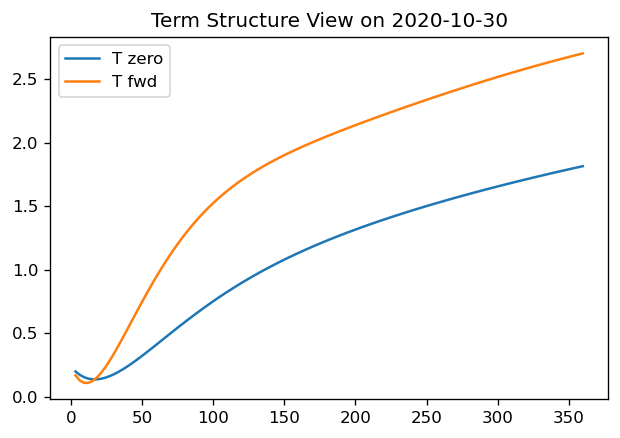

In [31]:
plt.figure(1,dpi=120)
l1, = plt.plot(Treasury_zero.columns, Treasury_zero.loc['2020-10-30'])
l2, = plt.plot(Treasury_fwd.columns, Treasury_fwd.loc['2020-10-30'])
plt.legend(handles=[l1,l2], labels = ['T zero','T fwd'], loc='best')
plt.title('Term Structure View on 2020-10-30')

Text(0.5, 1.0, 'Term Structure View on 2020-10-30')

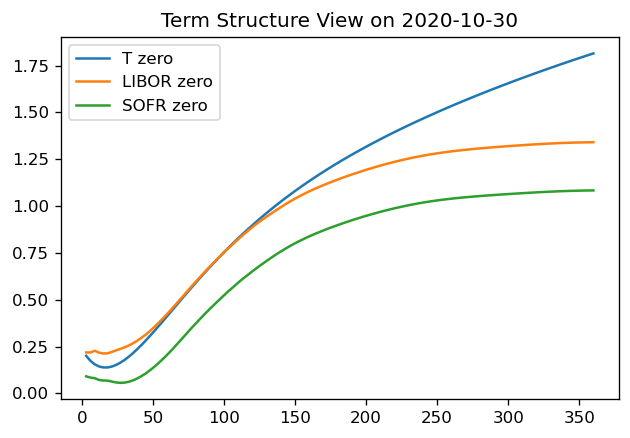

In [32]:
plt.figure(2,dpi=120)
l1, = plt.plot(Treasury_zero.columns, Treasury_zero.loc['2020-10-30'])
l2, = plt.plot(LIBOR_zero.columns, LIBOR_zero.loc['2020-10-30'])
l3, = plt.plot(SOFR_zero.columns, SOFR_zero.loc['2020-10-30'])
plt.legend(handles=[l1,l2,l3], labels = ['T zero','LIBOR zero','SOFR zero'], loc='best')
plt.title('Term Structure View on 2020-10-30')

Text(0.5, 1.0, 'Term Structure View on 2020-10-30')

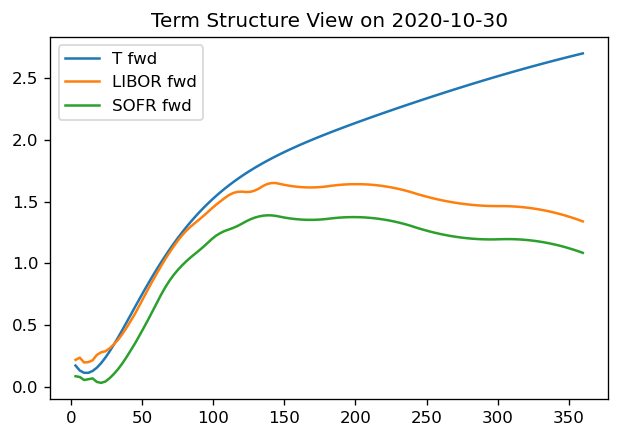

In [33]:
plt.figure(3,dpi=120)
l1, = plt.plot(Treasury_fwd.columns, Treasury_fwd.loc['2020-10-30'])
l2, = plt.plot(LIBOR_fwd.columns, LIBOR_fwd.loc['2020-10-30'])
l3, = plt.plot(SOFR_fwd.columns, SOFR_fwd.loc['2020-10-30'])
plt.legend(handles=[l1,l2,l3], labels = ['T fwd','LIBOR fwd','SOFR fwd'], loc='best')
plt.title('Term Structure View on 2020-10-30')

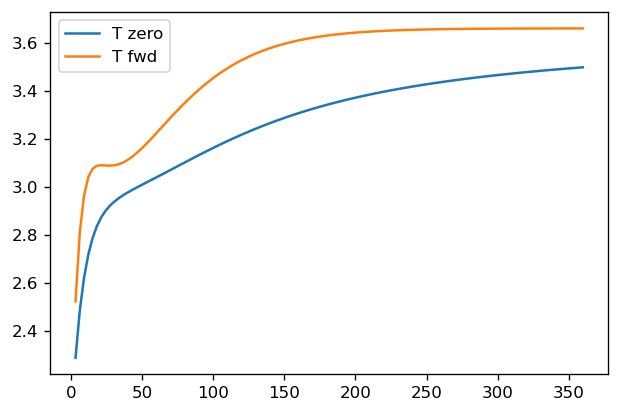

In [34]:
plt.figure(4,dpi=120)
l1, = plt.plot(Treasury_zero.columns, Treasury_zero.loc['2018-11-02'])
l2, = plt.plot(Treasury_fwd.columns, Treasury_fwd.loc['2018-11-02'])
plt.legend(handles=[l1,l2], labels = ['T zero','T fwd'], loc='best')

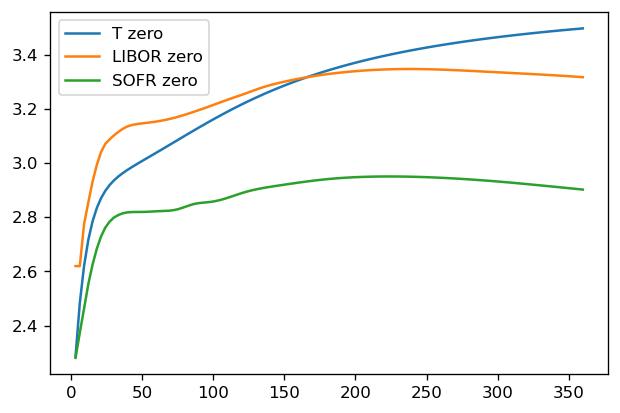

In [35]:
plt.figure(5,dpi=120)
l1, = plt.plot(Treasury_zero.columns, Treasury_zero.loc['2018-11-02'])
l2, = plt.plot(LIBOR_zero.columns, LIBOR_zero.loc['2018-11-02'])
l3, = plt.plot(SOFR_zero.columns, SOFR_zero.loc['2018-11-02'])
plt.legend(handles=[l1,l2,l3], labels = ['T zero','LIBOR zero','SOFR zero'], loc='best')

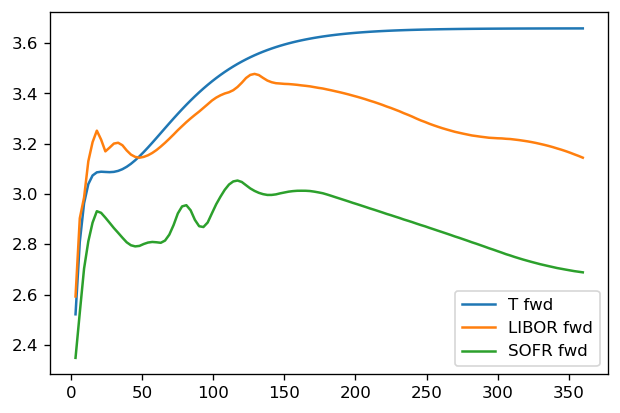

In [36]:
plt.figure(6,dpi=120)
l1, = plt.plot(Treasury_fwd.columns, Treasury_fwd.loc['2018-11-02'])
l2, = plt.plot(LIBOR_fwd.columns, LIBOR_fwd.loc['2018-11-02'])
l3, = plt.plot(SOFR_fwd.columns, SOFR_fwd.loc['2018-11-02'])
plt.legend(handles=[l1,l2,l3], labels = ['T fwd','LIBOR fwd','SOFR fwd'], loc='best')

## Visulization for time series

Text(0.5, 1.0, '2yr Tenor Time Series View')

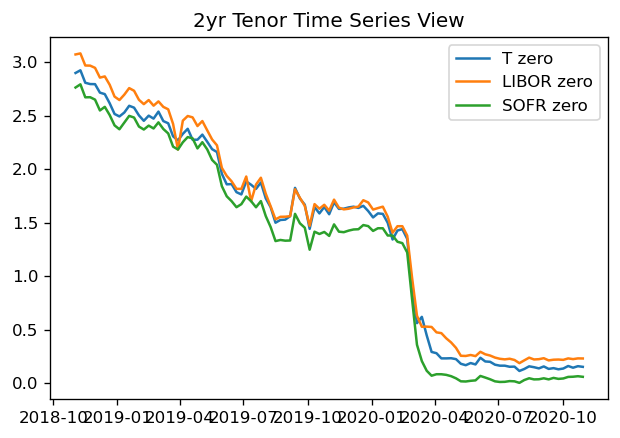

In [38]:
plt.figure(7,dpi=120)
l1, = plt.plot(Treasury_zero.index, Treasury_zero[24])
l2, = plt.plot(LIBOR_zero.index, LIBOR_zero[24])
l3, = plt.plot(SOFR_zero.index, SOFR_zero[24])
plt.legend(handles=[l1,l2,l3], labels = ['T zero','LIBOR zero','SOFR zero'], loc='best')
plt.title('2yr Tenor Time Series View')

Text(0.5, 1.0, '10yr Tenor Time Series View')

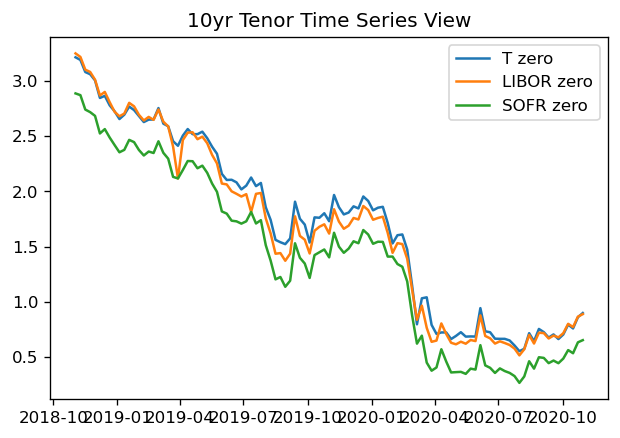

In [39]:
plt.figure(8,dpi=120)
l1, = plt.plot(Treasury_zero.index, Treasury_zero[120])
l2, = plt.plot(LIBOR_zero.index, LIBOR_zero[120])
l3, = plt.plot(SOFR_zero.index, SOFR_zero[120])
plt.legend(handles=[l1,l2,l3], labels = ['T zero','LIBOR zero','SOFR zero'], loc='best')
plt.title('10yr Tenor Time Series View')

Text(0.5, 1.0, '30yr Tenor Time Series View')

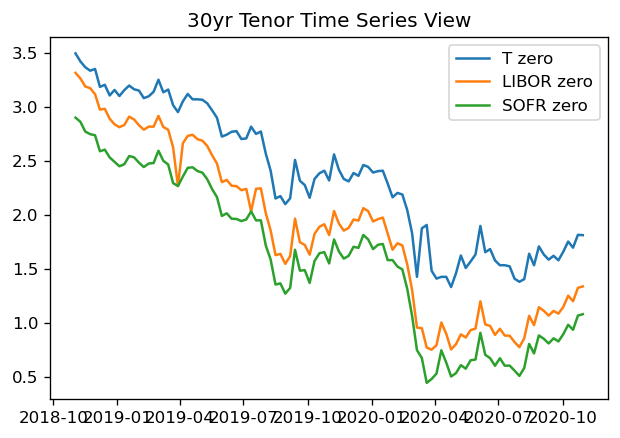

In [40]:
plt.figure(9,dpi=120)
l1, = plt.plot(Treasury_zero.index, Treasury_zero[360])
l2, = plt.plot(LIBOR_zero.index, LIBOR_zero[360])
l3, = plt.plot(SOFR_zero.index, SOFR_zero[360])
plt.legend(handles=[l1,l2,l3], labels = ['T zero','LIBOR zero','SOFR zero'], loc='best')
plt.title('30yr Tenor Time Series View')

### Store clean dataset

In [48]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter(r'C:\Users\Richard\Desktop\CurrentTerm\ISYE 8900\CurveFrcst-Using-ManifoldLrn\Data\LIBOR_clean.xlsx')
# Write each dataframe to a different worksheet
LIBOR_zero.to_excel(writer, sheet_name='zero')
LIBOR_fwd.to_excel(writer, sheet_name='forward')
# Close the Pandas Excel writer and output the Excel file.
writer.save()
writer.close()

In [49]:
with pd.ExcelWriter(r'C:\Users\Richard\Desktop\CurrentTerm\ISYE 8900\CurveFrcst-Using-ManifoldLrn\Data\SOFR_clean.xlsx') as writer:
    SOFR_zero.to_excel(writer, sheet_name='zero')
    SOFR_zero.to_excel(writer, sheet_name='forward')

with pd.ExcelWriter(r'C:\Users\Richard\Desktop\CurrentTerm\ISYE 8900\CurveFrcst-Using-ManifoldLrn\Data\Treasury_clean.xlsx') as writer:
    Treasury_zero.to_excel(writer, sheet_name='zero')
    Treasury_zero.to_excel(writer, sheet_name='forward')